### Проект: вариант 1

##### Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных     определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode

import pingouin as pg

OUTDATED_IGNORE=1
OUTDATED_RAISE_EXCEPTION=1

### Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков.

Начнем с развед анализа.

In [2]:
file_path_reg  = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-manzhos/shared/problem1-reg_data.csv'
file_path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-manzhos/shared/problem1-auth_data.csv'

In [3]:
df_reg  = pd.read_csv(file_path_reg, sep=';')
df_auth = pd.read_csv(file_path_auth, sep=';')

OUTDATED_IGNORE=1
OUTDATED_RAISE_EXCEPTION=1

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [8]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [12]:
df_reg.reg_ts   = pd.to_datetime(df_reg.reg_ts, unit='s').dt.date
df_auth.auth_ts = pd.to_datetime(df_auth.auth_ts, unit='s').dt.date

In [13]:
df_retention = df_reg.merge(df_auth, on='uid')
df_retention.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [14]:
df_retention.shape[0]

9601013

In [15]:
df_retention.uid.nunique()

1000000

In [16]:
print('min', df_retention.reg_ts.min(), '/ max', df_retention.reg_ts.max())

min 1998-11-18 / max 2020-09-23


Полученненый датафрейм составляет - 9601013 строк от - 1000000 айди, зарегистрированными с min 1998-11-18 / max 2020-09-23 датами/\.
Для выборки расчета retention возьмем 14 дней.

In [17]:
# data - исходные данные
# date_start - начальная дата
# interval - интервал исследуемых дней

def calculation_retention(data, date_start, interval):
    date_start = pd.to_datetime(date_start)
    date_end   = date_start + pd.DateOffset(days=interval)
    
    
    # сортируем нужный нам интервал
    interval_data = \
        data        \
            .loc[(data['reg_ts'] >= date_start) & (data['reg_ts'] <= date_end)]
    
    
    # групируем пользователей по когортам
    cohort_data   =   \
        interval_data \
            .groupby(['reg_ts', 'auth_ts']) \
            .agg(quantity_uniq_auth=('uid', 'nunique')).reset_index()

    cohort_data \
        .sort_values(['reg_ts', 'auth_ts'], ascending=[True, True], inplace=True)
    
    
    # считаем ретеншен
    cohort_data['quantity_uniq_reg'] =  \
        cohort_data                     \
            .groupby('reg_ts')['quantity_uniq_auth'].transform('max')
    
    cohort_data['retention']         =  \
        100 * (cohort_data['quantity_uniq_auth'] / cohort_data['quantity_uniq_reg'])
    
    cohort_data['days']              =  \
        (cohort_data['auth_ts'] - cohort_data['reg_ts']).dt.days
    
    # убираем нулевой день, создаем таблицу
    pivot_table                      =       \
        cohort_data[cohort_data['days'] > 0] \
            .pivot(index='reg_ts', columns='days', values='retention').fillna(0).round(5)
    
    # красиво оформляем хит мапом
    plt.figure(figsize=(24, 12))
    sns.heatmap(pivot_table, annot=True, cmap='Blues')
    sns.despine()
    
    return plt.show()

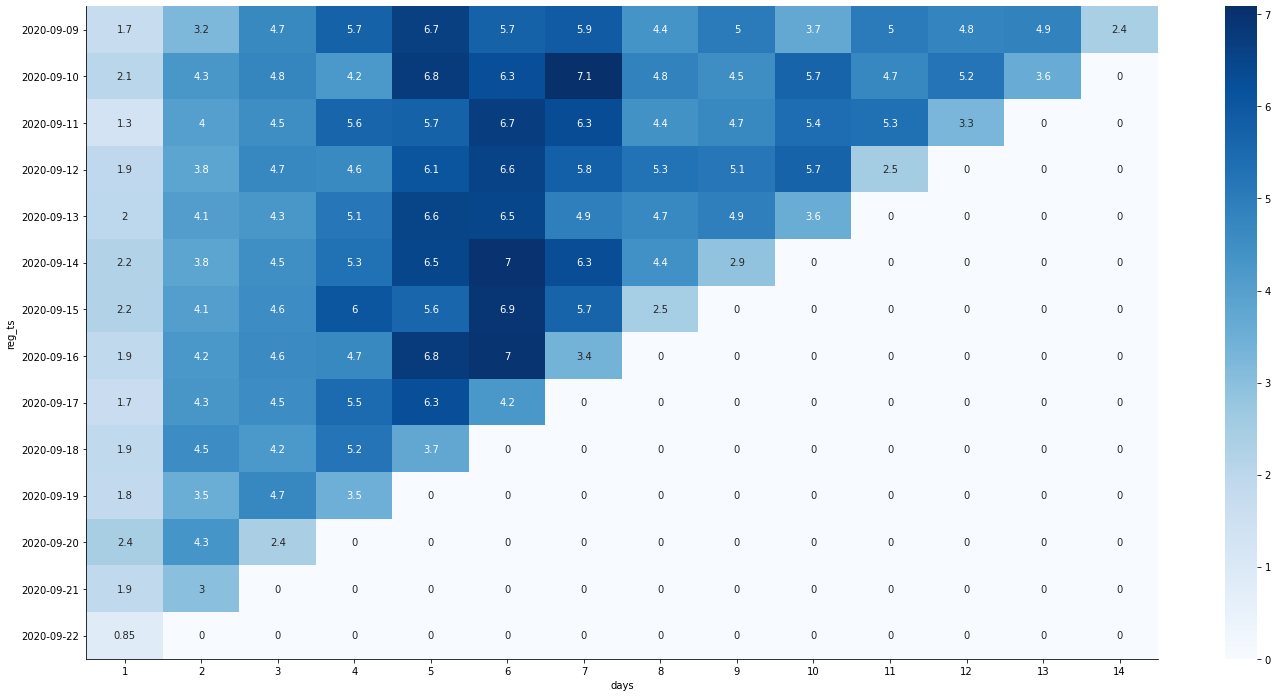

In [18]:
calculation_retention(df_retention, '2020-09-09', 14)

### Вывод:
- Максимальная доля пользователей приходится на 4-7 день, после чего снижается.

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [19]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

url_dict = {
        'task_one'  : {'file_name': 'Проект_1_Задание_2.csv', 'public_key': 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'}
        }

In [20]:
def download_files(url_dictionary, dataset):
    
    final_url = base_url + urlencode(dict(public_key=url_dictionary[dataset]['public_key']))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    df = pd.read_csv(download_url, sep=';')
    return df

In [21]:
df_ab = download_files(url_dict, 'task_one')

In [22]:
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [23]:
df_ab.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [24]:
df_ab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [25]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Рассмотрим различные метрики, как например, ARPU, ARPPU и CR. Необходимо также оценить схожесть групп по объему и доле платящих пользователей. Следует проверить сравнимы ли средние значения выручки в группах, используя describe и наличие статистически значимых отличий.

Примененим t-тест. При этом необходимо убедиться в нормальности и гамогенности выборок. В случае наличия значительных выбросов целесообразно воспользоваться тестом Манна-Уитни.



In [26]:
df_a = df_ab.query('testgroup == "a"')
df_b = df_ab.query('testgroup == "b"')
print('a', df_a.shape, 'and', 'b', df_b.shape)

a (202103, 3) and b (202667, 3)


In [27]:
df_ab \
    .groupby('testgroup', as_index=False) \
    .agg({'revenue':'sum','user_id':'count'})

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


In [28]:
df_ab \
    .query('revenue > 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'revenue':'sum','user_id':'count'})

,testgroup,revenue,user_id
0,a,5136189,1928
1,b,5421603,1805


Мы наблюдаем, что группы сравнимы как по количеству платящих пользователей, так и по среднему чеку. Проведем расчеты ARPU, ARPPU и CR для каждой группы.

In [29]:
ARPU_a = df_a['revenue'].sum() / df_a['user_id'].count()
ARPU_b = df_b['revenue'].sum() / df_b['user_id'].count()

In [30]:
print('a', ARPU_a.round(1), 'and', 'b', ARPU_b.round(1))

a 25.4 and b 26.8


In [31]:
df_paying = \
    df_ab   \
        .query('revenue > 0') \
        .groupby('testgroup') \
        .agg({'revenue':'sum','user_id':'count'})

In [32]:
ARPPU_a = df_paying.query('testgroup == "a"').revenue / df_paying.query('testgroup == "a"').user_id
ARPPU_b = df_paying.query('testgroup == "b"').revenue / df_paying.query('testgroup == "b"').user_id

In [33]:
ARPPU_a

testgroup
a    2663.998444
dtype: float64

In [34]:
ARPPU_b

testgroup
b    3003.658172
dtype: float64

In [35]:
CR_a = df_a[df_a.revenue > 0]['user_id'].count()/df_a['user_id'].count()
CR_b = df_b[df_b.revenue > 0]['user_id'].count()/df_b['user_id'].count()

In [36]:
print('a', CR_a.round(5), 'and', 'b', CR_b.round(5))

a 0.00954 and b 0.00891


Сравним describe разных выборок по платящим.

In [37]:
df_a_paying = \
    df_a \
        .query('revenue > 0')
df_a_paying.describe().round(1)

,user_id,revenue
count,1928.0,1928.0
mean,200152.7,2664.0
std,116596.5,9049.0
min,73.0,200.0
25%,99323.0,257.0
50%,199854.5,311.0
75%,299664.2,361.0
max,404768.0,37433.0


In [38]:
df_b_paying = \
    df_b \
        .query('revenue > 0')
df_b_paying.describe().round(1)

,user_id,revenue
count,1805.0,1805.0
mean,205834.5,3003.7
std,116400.0,572.6
min,161.0,2000.0
25%,106815.0,2513.0
50%,206651.0,3022.0
75%,304907.0,3478.0
max,404526.0,4000.0


Так же визуализируем для наглядности.

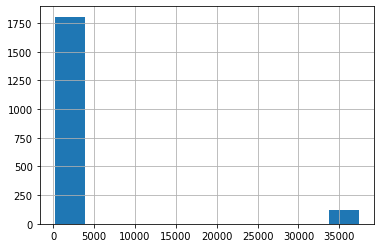

In [39]:
df_a_paying.revenue.hist()

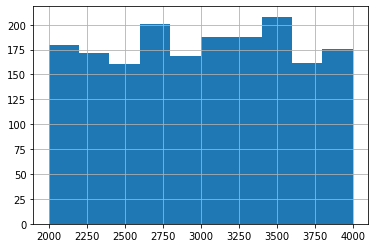

In [40]:
df_b_paying.revenue.hist()

Проверим на нормальность.

In [41]:
pg.normality(df_ab, dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Распределение не нормальное.

Проверим на гамогенность.

In [42]:
pg.homoscedasticity(df_ab, dv='revenue', group='testgroup')

,W,pval,equal_var
levene,0.389629,0.532495,True


Выборки гамогенны.

Проверим на нормальность платящих клиентов.

In [43]:
df_ab['pay'] = df_ab['revenue'].apply(lambda x: 1 if (x>0) else 0)

In [44]:
pg.normality(df_ab, dv='pay', group='testgroup', method='normaltest')

,W,pval,normal
b,317066.773364,0.0,False
a,309937.129243,0.0,False


Распределение не нормальное.

Проверим на гамогенность.

In [45]:
pg.homoscedasticity(df_ab, dv="pay", group="testgroup")

,W,pval,equal_var
levene,4.443811,0.035029,False


Выборки не гамогенны.

Применим т-тест к ARPU и ARPPU.

ARPU -

In [46]:
pg.ttest(df_a.revenue, df_b.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Так как p-val = 0.53 и > 0.05, то отклонить нулевую гипотезу не можем.
Это означает, то что контрольная группа стат значимо не отличется от тестовой.

ARPPU -

In [47]:
df_a_pay = df_a.query('revenue > 0')

In [48]:
df_b_pay = df_b.query('revenue > 0')

In [49]:
pg.ttest(df_a_pay.revenue, df_b_pay.revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


Так как p-val = 0.1 и > 0.05, то отклонить нулевую гипотезу не можем. Это означает, то что контрольная группа стат значимо не отличется от тестовой.

Применим хи-квадрат к конверсии.

In [50]:
expected, observed, stats = pg.chi2_independence(df_ab, x='testgroup',
                                                 y='pay')

In [51]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


Так как p-val = 0.036~ и < 0.05, то отклонить нулевую гипотезу мы можем. Это означает, то что контрольная группа стат значимо отличается от тестовой.

### Вывод:
- Из проведении статистических тестов, только Конверсия имеет различие.
CR контрольной группы выше, чем тестовой. Делая вывод что не стоит выкатывать наборы акционных предложений.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики представляют собой количественные показатели, которые позволяют оценить успешность продукта или бизнес-деятельности. 

Метрики для оценки количество игроков (аудитории):
- DAU (Daily Active Users) - количество уникальных пользователей, посетивших приложение за день.
- MAU (Monthly Active Users) - количество уникальных пользователей, посетивших приложение за месяц.
- WAU (Weekly Active Users) - количество уникальных пользователей, посетивших приложение за неделю.
- PCU (Peak Concurrent Users) - максимальное количество пользователей, находившихся одновременно в приложении в определенный период времени.
- ACU (Average Concurrent Users) - среднее количество пользователей, находившихся одновременно в приложении в определенный период времени.
- installs (установки) - количество установок приложения.
- Churn rate - показатель оттока пользователей.

Метрики для оценки вовлеченности:
- Retention (удержание) - показатель возвращаемости пользователей в продукт.
- Session - продолжительность времени, проведенного пользователем в мобильном приложении.
- ASD (Average Session Duration) - средняя продолжительность сессии за определенный период времени.

Метрики доходности:
- ARPU (Average Revenue Per User) - средний доход с каждого пользователя.
- ARPPU (Average Revenue Per Paying User) - средний доход с каждого платящего пользователя.
- LTV (Lifetime Value) - пожизненная ценность клиента.
- ATV (Average Transaction Value) - средняя стоимость покупки за период.

Метрики расходов:
- CPI (Cost Per Install) - стоимость привлечения нового пользователя в приложение.
- ROI (Return on Investment) - окупаемость бизнеса.
- ROMI (Return on Marketing Investment) и ROAS (Return on Advertising Spend) - показатели окупаемости маркетинговых расходов.

Дополнительные метрики:
- Длина сессии - среднее время пребывания пользователя в игре.
- Среднее время прохождения уровня.
- FUUU-фактор - метрика, отражающая негативные эмоции игрока.

При откате на несколько уровней возникнет негативный эффект, что приведет к потере пользователей, особенно новичков. При анализе среднего времени прохождения уровня следует учитывать каждого игрока индивидуально, исключая тех, кто не завершил уровень, чтобы избежать искажений. Следует оценивать количество откатывающихся игроков и процент успешных прохождений, чтобы корректировать сложность уровней. Возможно стоит предоставлять откатывающимся игрокам "утешительные призы" в виде полезных артефактов или дополнительных жизней, чтобы увеличить их лояльность к игре.

In [52]:
# ⣿⣿⣿⣿⡟⠛⠁⠄⠄⠄⠄⢀⣀⣀⠄⠄⠄⠄⣤⣽⣿⣿⣿⣿⣿⣿⣿⣿ #
# ⣿⣿⣿⡋⠁⠄⠄⠄⣠⣶⣾⣿⣿⣿⣿⠄⢦⡄⠐⠬⠛⢿⣿⣿⣿⣿⣿⣿ #
# ⣿⡿⠇⠁⠄⠄⣠⣾⣿⣿⡿⠟⠋⠁⠄⠄⠈⠁⠄⠄⠄⠄⠙⢿⣿⣿⣿⣿ #
# ⣿⠃⠄⠄⠄⠘⣿⣿⣿⣿⢀⣠⠄⠄⠄⠄⣰⣶⣀⠄⠄⠄⠄⠸⣿⣿⣿⣿ #
# ⣏⠄⠄⠄⠄⠄⣿⣿⣿⡿⢟⣁⠄⣀⣠⣴⣿⣿⠿⠷⠶⠒⠄⠄⢹⣿⣿⣿ #
# ⡏⠄⠄⠄⠄⢰⣿⣿⣿⣿⣿⣿⣿⣿⡟⠄⠛⠁⠄⠄⠄⠄⠄⠄⢠⣿⣿⣿ #
# ⡇⠄⠄⠄⠄⠈⢿⣿⣿⣿⣿⣿⣿⣿⡇⠄⣼⣿⠇⠘⠄⠁⠄⠄⠄⢻⣿⣿ #
# ⣇⠄⠄⠄⠄⠄⠸⢿⣿⣿⣿⣿⣿⣿⠁⠸⠟⠁⣠⣤⣤⣶⣤⠄⠄⠄⢻⣿ #
# ⣿⡄⠄⡤⢤⣤⡀⠈⣿⣿⣿⣿⣿⣿⡆⠄⠄⠘⠋⠁⠄⠄⠈⠄⠄⠄⢸⣿ #
# ⣿⣿⡜⢰⡾⢻⣧⣰⣿⣿⣿⣿⣿⣿⣷⠄⣼⣷⣶⣶⡆⠄⠄⠄⠄⠄⠄⣿ #
# ⣿⣿⣧⢸⠄⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⣿⣿⣿⠄⠄⠄⠄⠄⠄⠄⣿ #
# ⣿⣿⣿⣿⡿⢿⡟⠉⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⠄⠄⢀⡀⠄⠘⣿ #
# ⣿⣿⣿⣿⣿⣆⢻⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠟⠋⠄⠄⠈⠁⠄⠄⣿ #
# ⣿⣿⣿⣿⣿⣿⡆⢻⣿⣿⣿⣿⣿⣿⡿⠛⠛⠛⠃⠄⠄⠄⠄⠄⠄⠄⢀⣿ #
# ⣿⣿⣿⣿⣿⣿⣿⣆⣻⣿⣿⣿⣿⣿⣷⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⢸⣿ #